# MSF 모델

- mfcc, spectrogram , mel-spectrogram 3채널을 엮어서 학습을 해본다.
- 이미지는 300 x 300 으로 고정하고, mfcc 100을 interpolate 한다.
- fusion 실시 x
- grad-cam 포함


- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import wandb

wandb.init(project="SVD-voice-disorder", entity="bub3690")
wandb.run.name = 'MSF-organic-baseline-sigpadding'
wandb.run.save()

wandb: Currently logged in as: bub3690. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
import wandb

sweep_config = {
  "name": "HyperParam for mel",
  "method": "grid",
  "parameters": {
        "param1": {
            "values": [1, 2, 3]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

p = os.path.abspath('../../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [3]:
import torchaudio
import torchaudio.transforms as T

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [4]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


## 2. stratified k-fold

In [5]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 95} 



## 3. random over sampling

In [6]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})

 fold1 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold2 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold3 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold4 
before dataset shape Counter({'healthy': 406, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})


In [7]:
import pickle

 
#load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 300frame)
- 전처리 방법 결정.


In [44]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



classes = ["pathology","healthy"]
sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None,augment=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.augment=augment
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc, spectro, mel-spectro를 추출
        2. mfcc를 224프레임으로 패딩. 또한 세로축은 224으로 interpolate
        3. resnet에 사용되기 위해 3채널로 쌓기.
        4. 미정. 0~1 정규화
        
        """
        sig =  phrase_dict[self.path_list[idx]] # 16000hz 실시
        length=29990 #300 padding을 위한 파라미터
        pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        
        MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
        #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
        #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로
        
        
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        
        
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        #stft 300 FRAME이 되도록 패딩.
        #length = 300

        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm
        
        
        #padding
        #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        #log_spectrogram = pad2d(log_spectrogram, length)
        #mel_feature = pad2d(mel_feature, length)
        
        #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
        log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
        
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)# 타입 변화
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화            
            
            MSF = torch.stack([log_spectrogram,mel_feature,MFCCs])# 3채널로 복사.
            #augmentation
            if self.training and self.augment:
                MSF = MSF.squeeze(dim=1)
                MSF=self.augment(MSF)
            else:
                MSF = MSF.squeeze(dim=1)
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx])
    
    

In [45]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc, spectro, mel-spectro를 추출
        2. mfcc를 300프레임으로 패딩. 또한 세로축은 128으로 interpolate
        3. resnet에 사용되기 위해 3채널로 쌓기.
        4. 미정. 0~1 정규화
        
        """
        sig =  phrase_dict[self.path_list[idx]] # 16000hz 실시
        length=29990 #300 padding을 위한 파라미터
        pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)
        
        
        
        
        
        MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
        #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
        #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로
        
        
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        
        
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        #stft 300 FRAME이 되도록 패딩.
        #length = 300

        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm
        
        
        #padding
        #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        #log_spectrogram = pad2d(log_spectrogram, length)

        
        #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
        log_spectrogram=log_spectrogram[:128,:]# 128 x 300 으로 사이즈 조절
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)# 타입 변화
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화
            
            
            MSF = torch.stack([log_spectrogram,mel_feature,MFCCs])# 3채널로 복사.
            MSF = MSF.squeeze(dim=1)
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [46]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복
lr=0.0001

In [40]:
wandb.config.update({
    "learning_rate": lr,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "augment":"No",
})

In [47]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인
#transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform=transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform=transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [48]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train :  torch.Size([32, 3, 128, 300]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

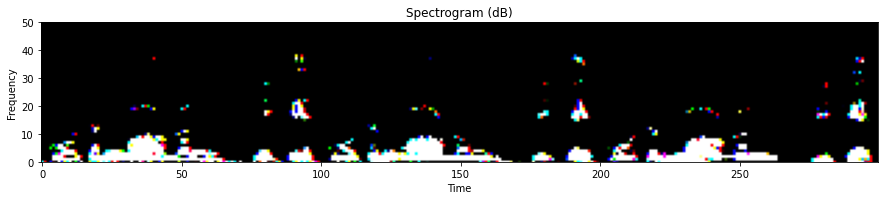

In [49]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
plt.figure(figsize=(15,5))
plt.imshow(X_train[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylim((0,50))
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

In [50]:
X_train.size()

torch.Size([32, 3, 128, 300])

In [51]:
X_train[0][0].shape

torch.Size([128, 300])

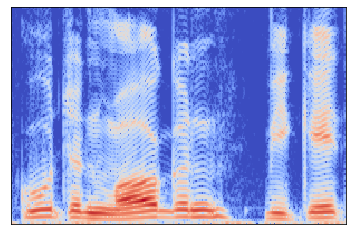

In [52]:
librosa.display.specshow(X_train[0][0].view(128,300).numpy(),sr=16000)

In [ ]:
X_train[0].size()

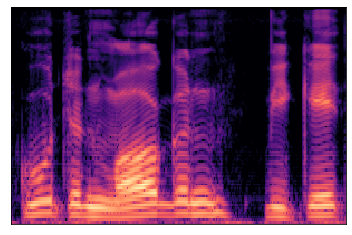

In [53]:
librosa.display.specshow(X_train[0][1].view(128,300).numpy(),sr=16000)

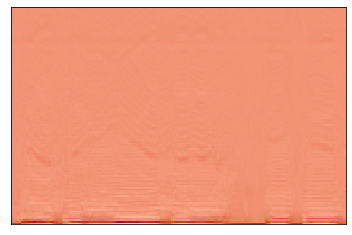

In [54]:
librosa.display.specshow(X_train[0][2].view(128,300).numpy(),sr=16000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_valid :  torch.Size([32, 3, 128, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

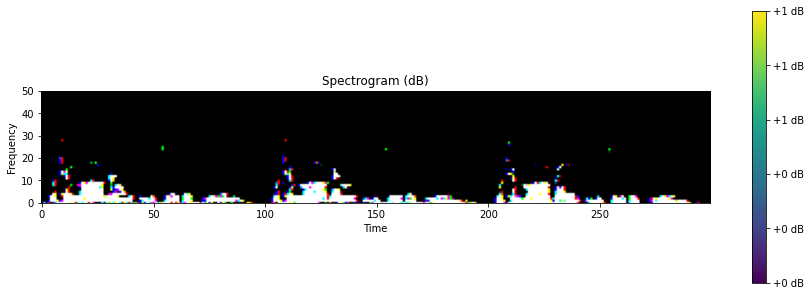

In [55]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
plt.figure(figsize=(15,5))
plt.imshow(X_valid[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.ylim((0,50))
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_valid :  torch.Size([32, 3, 128, 300]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

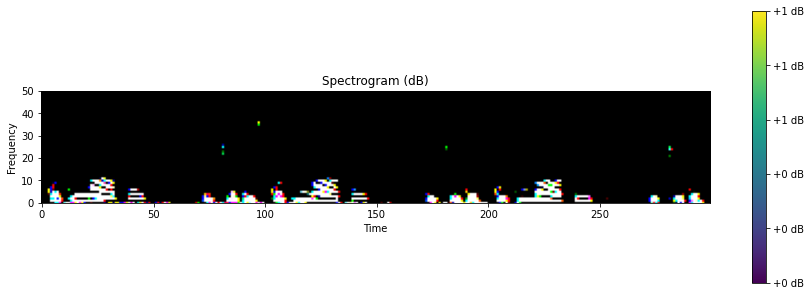

In [57]:
#valiation set 확인
for (test_data,test_label) in validation_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(test_label[0])
plt.figure(figsize=(15,5))
plt.imshow(test_data[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.ylim((0,50))
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [58]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Linear(num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [59]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy,self).__init__()
    def forward(self,x,target,smoothing=0.1):
        confidence =1.-smoothing
        logprobs = F.log_softmax(x,dim=-1)
        nll_loss = -logprobs.gather(dim=-1,index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing*smooth_loss
        return loss.mean()


In [60]:




criterion = nn.CrossEntropyLoss()
#criterion = LabelSmoothingCrossEntropy()


optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [62]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        #loss = softXEnt(output,label)
        
        train_loss += loss.item()
        
        
        output = F.softmax(output, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [63]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            valid_loss += criterion(output, label).item()
            #valid_loss +=softXEnt(output,label).item()
            
            output = F.softmax(output, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만

            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [64]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [65]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_msf_organic_base_sigpad.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)
        wandb.log({
                "valid {}fold Accuracy".format(data_ind) : valid_accuracy,
                "valid {}fold loss".format(data_ind) : valid_loss})

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
            wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc})
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

../../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_300_msf_organic_base_sigpad.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0204	 Train Acc:64.66 %  | 	Valid Loss:0.0192 	Valid Acc: 76.65 %

Validation loss decreased (inf --> 0.019169).  Saving model ...

[EPOCH:2]	 Train Loss:0.0169	 Train Acc:76.97 %  | 	Valid Loss:0.0169 	Valid Acc: 79.70 %

Validation loss decreased (0.019169 --> 0.016879).  Saving model ...

[EPOCH:3]	 Train Loss:0.0144	 Train Acc:83.74 %  | 	Valid Loss:0.0171 	Valid Acc: 80.20 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0132	 Train Acc:85.84 %  | 	Valid Loss:0.0165 	Valid Acc: 80.20 %

Validation loss decreased (0.016879 --> 0.016454).  Saving model ...

[EPOCH:5]	 Train Loss:0.0113	 Train Acc:91.38 %  | 	Valid Loss:0.0155 	Valid Acc: 80.20 %

Validation loss decreased (0.016454 --> 0.015466).  Saving model ...

[EPOCH:6]	 Train Loss:0.0103	 Train Acc:94.58 %  | 	Valid Loss:0.0152 	Valid Acc: 80.71 %

Validation loss decreased (0.0


[EPOCH:5]	 Train Loss:0.0093	 Train Acc:94.20 %  | 	Valid Loss:0.0144 	Valid Acc: 84.77 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0080	 Train Acc:97.04 %  | 	Valid Loss:0.0123 	Valid Acc: 85.28 %

Validation loss decreased (0.014378 --> 0.012251).  Saving model ...

[EPOCH:7]	 Train Loss:0.0070	 Train Acc:97.41 %  | 	Valid Loss:0.0129 	Valid Acc: 85.28 %

EarlyStopping counter: 1 out of 5

[EPOCH:8]	 Train Loss:0.0059	 Train Acc:99.26 %  | 	Valid Loss:0.0134 	Valid Acc: 86.29 %

EarlyStopping counter: 2 out of 5

[EPOCH:9]	 Train Loss:0.0055	 Train Acc:99.14 %  | 	Valid Loss:0.0120 	Valid Acc: 85.28 %

Validation loss decreased (0.012251 --> 0.012027).  Saving model ...

[EPOCH:10]	 Train Loss:0.0046	 Train Acc:100.00 %  | 	Valid Loss:0.0131 	Valid Acc: 85.79 %

EarlyStopping counter: 1 out of 5

[EPOCH:11]	 Train Loss:0.0043	 Train Acc:99.88 %  | 	Valid Loss:0.0118 	Valid Acc: 86.80 %

Validation loss decreased (0.012027 --> 0.011768).  Saving model ...

[EPOCH:12


[EPOCH:16]	 Train Loss:0.0035	 Train Acc:100.00 %  | 	Valid Loss:0.0103 	Valid Acc: 88.27 %

Validation loss decreased (0.010439 --> 0.010286).  Saving model ...

[EPOCH:17]	 Train Loss:0.0031	 Train Acc:99.75 %  | 	Valid Loss:0.0138 	Valid Acc: 88.27 %

EarlyStopping counter: 1 out of 5

[EPOCH:18]	 Train Loss:0.0031	 Train Acc:99.63 %  | 	Valid Loss:0.0121 	Valid Acc: 88.78 %

EarlyStopping counter: 2 out of 5

[EPOCH:19]	 Train Loss:0.0030	 Train Acc:99.75 %  | 	Valid Loss:0.0104 	Valid Acc: 89.29 %

EarlyStopping counter: 3 out of 5

[EPOCH:20]	 Train Loss:0.0024	 Train Acc:100.00 %  | 	Valid Loss:0.0111 	Valid Acc: 88.27 %

EarlyStopping counter: 4 out of 5

[EPOCH:21]	 Train Loss:0.0024	 Train Acc:100.00 %  | 	Valid Loss:0.0111 	Valid Acc: 87.76 %

EarlyStopping counter: 5 out of 5
[5 교차검증] Early stopping


# Model 결과 확인


In [66]:

sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 100.0000 |	 valid ACC: 81.2183 
[2 교차검증] train ACC : 99.6305 |	 valid ACC: 87.8173 
[3 교차검증] train ACC : 99.2593 |	 valid ACC: 88.3249 
[4 교차검증] train ACC : 100.0000 |	 valid ACC: 88.8325 
[5 교차검증] train ACC : 100.0000 |	 valid ACC: 88.2653 
평균 검증 정확도 86.89163990469284 %


# Model Test

- test set
- confusion matrix

In [69]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [68]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_msf_organic_base_sigpad.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[1,0])
    
    specificity=cf[1,1]/(cf[0,1]+cf[1,1])
    average_uar += (specificity+recall)/2
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    #print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    #### wandb
    
    wandb.run.summary.update({"test_{}fold_acc".format(data_ind) : acc*100})
    wandb.run.summary.update({"test_{}fold_f1".format(data_ind) : fscore})
    wandb.run.summary.update({"test_{}fold_UAR".format(data_ind) : (specificity+recall)/2})
    wandb.log({"{}fold Confusion Matrix".format(data_ind) :wandb.sklearn.plot_confusion_matrix(answers, predictions, labels=classes)})
    
    ####
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))
wandb.run.summary.update({"test 평균 acc" : average_accuracy/5})
wandb.run.summary.update({"test 평균 f1" : average_fscore/5})
wandb.run.summary.update({"test 평균 UAR" : average_uar/5})



1번 모델
Accuracy : 87.0445% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8793
specificity : 0.8626%
UAR : 0.8710%
f score : 0.8702 
[[102  18]
 [ 14 113]]
-----
2번 모델
Accuracy : 86.2348% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8839
specificity : 0.8444%
UAR : 0.8642%
f score : 0.8618 
[[ 99  21]
 [ 13 114]]
-----
3번 모델
Accuracy : 88.6640% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8833
specificity : 0.8898%
UAR : 0.8865%
f score : 0.8865 
[[106  14]
 [ 14 113]]
-----
4번 모델
Accuracy : 86.6397% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8537
specificity : 0.8790%
UAR : 0.8663%
f score : 0.8664 
[[105  15]
 [ 18 109]]
-----
5번 모델
Accuracy : 87.4494% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8803
specificity : 0.8692%
UAR : 0.8748%
f score : 0.8743 
[[103  17]
 [ 14 113]]
-----
평균 acc : 0.8721
평균 UAR : 0.8726
평균 f1score : 0.8718


## validation set 답 정리
- 분포 확인

In [ ]:
#분포 확인 위해 수정
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



classes = ["pathology","healthy"]
sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None,augment=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.augment=augment
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc, spectro, mel-spectro를 추출
        2. mfcc를 224프레임으로 패딩. 또한 세로축은 224으로 interpolate
        3. resnet에 사용되기 위해 3채널로 쌓기.
        4. 미정. 0~1 정규화
        
        """
        sig =  phrase_dict[self.path_list[idx]] # 16000hz 실시
        length=29990 #300 padding을 위한 파라미터
        pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(pad1d)        
        
        MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
        #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
        #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로
        
        
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        
        
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        #stft 300 FRAME이 되도록 패딩.
        #length = 300

        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm
        
        
        #padding
        #pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        log_spectrogram = pad2d(log_spectrogram, length)
        #mel_feature = pad2d(mel_feature, length)
        #MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
        log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)# 타입 변화
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화            
            
            MSF = torch.stack([log_spectrogram,mel_feature,MFCCs])# 3채널로 복사.
            #augmentation
            if self.training:
                MSF=self.augment(MSF)     
            MSF = MSF.squeeze(dim=1)
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx]),self.path_list[idx]
    
    

In [ ]:
#confusion matrix 계산
#valid set 계산.
all_filename=[]
all_prediction=[]
all_answers=[]


def valid_evaluate(model,data_ind):
    model.eval()
    test_loss = 0
    file_name = []
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform=transforms.ToTensor(),
                                                   data_num=data_ind-1,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    
    with torch.no_grad():
        for image, label,path_list in validation_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            file_name+=(path_list)            
        all_filename.append(file_name)
        all_prediction.append(predictions)
        all_answers.append(answers)
        return predictions,answers,test_loss
            

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_msf_organic_aug.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers, valid_loss = valid_evaluate(model,data_ind)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




In [ ]:
len(all_filename)

In [ ]:
fold_excel = []
for i in range(5):
    fold_excel.append(pd.DataFrame({'filename':all_filename[i],
                  'prediction':[data.cpu().numpy().item() for data in all_prediction[i]],
                  'answer':[ data.cpu().numpy().item() for data in all_answers[i]],
                  'fold':i+1}))

In [ ]:
fold_excel_all=pd.concat(fold_excel,axis=0)

In [ ]:
answer_paper=pd.read_excel('D:/project/voice_pathology_ai/voice_data/only_organics_healthy.xlsx')
answer_paper.head()

In [ ]:
answer_paper['RECORDING']=answer_paper['RECORDING'].values.astype(str)

In [ ]:
answer_paper['RECORDING']=answer_paper['RECORDING']+'-phrase.wav'

In [ ]:
answer_paper[['RECORDING','DETAIL']]

In [ ]:
merge_left = pd.merge(fold_excel_all,answer_paper[['RECORDING','DETAIL']], how='left', left_on='filename', right_on='RECORDING')
merge_left

In [ ]:
merge_left.drop(['RECORDING'],axis=1,inplace=True)

In [ ]:
merge_left['result']=merge_left['prediction']==merge_left['answer']

In [ ]:
merge_left

In [ ]:
merge_left.to_excel('D:/project/voice_pathology_ai/voice_data/result_valid_organics_0523_aug.xlsx',index=False)

## validation cam

In [ ]:
# final conv layer name 
finalconv_name = 'layer4'

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []

transform_norm = transforms.ToTensor()

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy()) # 레이어의 마지막 output(피처맵)을 구하는 함수
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])  #backward시에 그래디언트 저장.

In [ ]:
#분포 확인 위해 수정
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



classes = ["pathology","healthy"]
sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None,augment=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.augment=augment
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        print()
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc, spectro, mel-spectro를 추출
        2. mfcc를 224프레임으로 패딩. 또한 세로축은 224으로 interpolate
        3. resnet에 사용되기 위해 3채널로 쌓기.
        4. 미정. 0~1 정규화
        
        """
        sig =  phrase_dict[self.path_list[idx]] # 16000hz 실시
        
        
        MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
        #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
        #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로
        
        
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        
        
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        #stft 300 FRAME이 되도록 패딩.
        length = 300

        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm
        
        
        #padding
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        log_spectrogram = pad2d(log_spectrogram, length)
        mel_feature = pad2d(mel_feature, length)
        MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
        log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)# 타입 변화
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화            
            
            MSF = torch.stack([log_spectrogram,mel_feature,MFCCs])# 3채널로 복사.
            #augmentation
            if self.training:
                MSF=self.augment(MSF)     
            MSF = MSF.squeeze(dim=1)
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx]), self.path_list[idx]
    
    

In [ ]:
CAM_BATCH_SIZE=1
finalconv_name

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image



#pathology 음성 파일 가져오기

length=300
image_list=[]

label_list=[]
prob_list=[] #valid set의 확률값
name_list=[] #파일명
predict_label_list=[] #예측 라벨
res = []



mel_list=[]#정규 mel-spectrogram 모은 리스트
fallout_list=[] # cam - mel . 음수는 0 처리.


model.eval()
mel_sample=None


for data_ind in  range(1,6):
    print("----------------")
    print(data_ind,'fold')
    print("----------------")
    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform=transforms.ToTensor(),
                                                   data_num=data_ind-1,
                                                   training=False
                                               ),
                                               batch_size = CAM_BATCH_SIZE,
                                               shuffle = True,) 
    for image, label, path in validation_loader:

        name = path[0].split('\\')[-1]
        name = name.replace('.wav', '')
        name_list.append(name)
        label_list.append(classes[label])

        # activations
        feature_blobs = []
        # gradient를 가져올 hook 함수
        backward_feature = []

        mel_sample = image
        mel_sample = mel_sample.to(DEVICE).float()


        model._modules.get(finalconv_name).register_forward_hook(hook_feature)
        model._modules.get(finalconv_name).register_backward_hook(backward_hook)



        # Prediction
        logit = model(mel_sample) # 예측값 구하기.
        out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
        probs, idx = out.sort(0, True)
        print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))
        predict_label_list.append(classes[idx[0].item()])
        prob_list.append(probs[0].item())
        res.append(classes[label]==classes[idx[0].item()])


        ###########
        # Grad - cam
        ###########

        score = logit[:, idx[0]].squeeze() # 예측값 y^c.
        score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

        activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
        gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
        b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
        #print(gradients.size())

        alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
        weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

        grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
        grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
        grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 128, 300)
        map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
        grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling

        grad_heatmap=grad_cam_map.squeeze().cpu()

        # grad_cam_map.squeeze() : (128, 300)

        #save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))

        # mel-spectorgram min-max normalization

        mel_min,mel_max = mel_sample.squeeze()[1].min(),mel_sample.squeeze()[1].max()
        mel_sample = (mel_sample.squeeze()[1]- mel_min).div(mel_max-mel_min)
        mel_sample = mel_sample.cpu().numpy()
        mel_list.append(mel_sample)


        #mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0]) #수정 필요. min-max normalization

        grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)

        fallout_list.append(grad_heatmap.numpy() - mel_sample)


        plt.figure(figsize=(10,5))
        plt.ion()
        plt.subplot(131)
        librosa.display.specshow(mel_sample, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram (dB)")

        plt.subplot(132)
        librosa.display.specshow(grad_heatmap.numpy(), sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram (dB)")

        plt.subplot(133)
        librosa.display.specshow(grad_result, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram (dB)")


        
        folder_path='D:/project/voice_pathology_ai/voice_data/aug_organics_cam_fold/'+str(data_ind)+'fold/'
        plt.ioff()
        plt.savefig(folder_path+name)
    

result_excel=pd.concat( [pd.DataFrame(name_list),
            pd.DataFrame(label_list),
            pd.DataFrame(predict_label_list),
            pd.DataFrame(prob_list),
            pd.DataFrame(res)],axis=1)
result_excel.columns=['name','class','predict','probability','result']
result_excel.to_excel("D:/project/voice_pathology_ai/voice_data/result_excel_fallout_valid.xlsx",index=False)



# train set 확인

## 결과 출력

In [ ]:
#confusion matrix 계산
#valid set 계산.
all_filename=[]
all_prediction=[]
all_answers=[]


def train_evaluate(model,data_ind):
    model.eval()
    test_loss = 0
    file_name = []
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform=transforms.ToTensor(),
                                                   data_num=data_ind-1,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    
    with torch.no_grad():
        for image, label,path_list in train_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            file_name+=(path_list)            
        all_filename.append(file_name)
        all_prediction.append(predictions)
        all_answers.append(answers)
        return predictions,answers,test_loss
            

In [ ]:
#분포 확인 위해 수정
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



classes = ["pathology","healthy"]
sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None,augment=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.augment=augment
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        print()
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc, spectro, mel-spectro를 추출
        2. mfcc를 224프레임으로 패딩. 또한 세로축은 224으로 interpolate
        3. resnet에 사용되기 위해 3채널로 쌓기.
        4. 미정. 0~1 정규화
        
        """
        sig =  phrase_dict[self.path_list[idx]] # 16000hz 실시
        
        
        MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
        #MFCCs = librosa.util.normalize(MFCCs) # l-infinity norm
        #MFCCs=cv2.resize(MFCCs,(MFCCs.shape[1],128),interpolation=cv2.INTER_LINEAR)# interpolate 적용해서 128 사이즈로
        
        
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        
        
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        #stft 300 FRAME이 되도록 패딩.
        length = 300

        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)
        #log_spectrogram = librosa.util.normalize(log_spectrogram) # l-infinity norm
        
        
        #padding
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        log_spectrogram = pad2d(log_spectrogram, length)
        mel_feature = pad2d(mel_feature, length)
        MFCCs = pad2d(MFCCs, length) # mfcc 대신 encoder를 가져와서 해보자.
        log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)# 타입 변화
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화            
            
            MSF = torch.stack([log_spectrogram,mel_feature,MFCCs])# 3채널로 복사.
            #augmentation
            if self.training and self.augment:
                MSF=self.augment(MSF)     
            MSF = MSF.squeeze(dim=1)
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx]), self.path_list[idx]
    
    

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_msf_organic_aug.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers, valid_loss = train_evaluate(model,data_ind)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




In [ ]:
len(all_filename)

In [ ]:
fold_excel = []
for i in range(5):
    fold_excel.append(pd.DataFrame({'filename':all_filename[i],
                  'prediction':[data.cpu().numpy().item() for data in all_prediction[i]],
                  'answer':[ data.cpu().numpy().item() for data in all_answers[i]],
                  'fold':i+1}))

In [ ]:
fold_excel_all=pd.concat(fold_excel,axis=0)

In [ ]:
answer_paper=pd.read_excel('D:/project/voice_pathology_ai/voice_data/only_organics_healthy.xlsx')
answer_paper.head()

In [ ]:
answer_paper['RECORDING']=answer_paper['RECORDING'].values.astype(str)
answer_paper['RECORDING']=answer_paper['RECORDING']+'-phrase.wav'
answer_paper[['RECORDING','DETAIL']]
merge_left = pd.merge(fold_excel_all,answer_paper[['RECORDING','DETAIL']], how='left', left_on='filename', right_on='RECORDING')
merge_left.drop(['RECORDING'],axis=1,inplace=True)
merge_left['result']=merge_left['prediction']==merge_left['answer']
merge_left

In [ ]:
merge_left.to_excel('D:/project/voice_pathology_ai/voice_data/result_train_organics_0523_aug.xlsx',index=False)

## train cam

In [ ]:
# final conv layer name 
finalconv_name = 'layer4'

# activations
feature_blobs = []

# gradient를 가져올 hook 함수
backward_feature = []

transform_norm = transforms.ToTensor()

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy()) # 레이어의 마지막 output(피처맵)을 구하는 함수
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])  #backward시에 그래디언트 저장.

In [ ]:
CAM_BATCH_SIZE=1
finalconv_name

In [ ]:
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image



#pathology 음성 파일 가져오기

length=300
image_list=[]

label_list=[]
prob_list=[] #valid set의 확률값
name_list=[] #파일명
predict_label_list=[] #예측 라벨
res = []



mel_list=[]#정규 mel-spectrogram 모은 리스트
fallout_list=[] # cam - mel . 음수는 0 처리.


model.eval()
mel_sample=None


for data_ind in  range(1,6):
    print("----------------")
    print(data_ind,'fold')
    print("----------------")
    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform=transforms.ToTensor(),
                                                   data_num=data_ind-1,
                                                   training=True
                                               ),
                                               batch_size = CAM_BATCH_SIZE,
                                               shuffle = True,) 
    for image, label, path in train_loader:

        name = path[0].split('\\')[-1]
        name = name.replace('.wav', '')
        name_list.append(name)
        label_list.append(classes[label])

        # activations
        feature_blobs = []
        # gradient를 가져올 hook 함수
        backward_feature = []

        mel_sample = image
        mel_sample = mel_sample.to(DEVICE).float()


        model._modules.get(finalconv_name).register_forward_hook(hook_feature)
        model._modules.get(finalconv_name).register_backward_hook(backward_hook)



        # Prediction
        logit = model(mel_sample) # 예측값 구하기.
        out = F.softmax(logit, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
        probs, idx = out.sort(0, True)
        print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))
        predict_label_list.append(classes[idx[0].item()])
        prob_list.append(probs[0].item())
        res.append(classes[label]==classes[idx[0].item()])


        ###########
        # Grad - cam
        ###########

        score = logit[:, idx[0]].squeeze() # 예측값 y^c.
        score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

        activations = torch.Tensor(feature_blobs[0]).to(DEVICE) # (1, 512, 7, 7), forward activations. append라서 0번이 마지막
        gradients = backward_feature[0] # (1, 512, 4, 10), backward gradients. 마지막 conv layer의 gradient
        b, k, u, v = gradients.size()  # batch, 피처맵 수,  상, 하
        #print(gradients.size())

        alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
        weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

        grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
        grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
        grad_cam_map = F.interpolate(grad_cam_map, size=(128, 300), mode='bilinear', align_corners=False) # (1, 1, 128, 300)
        map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
        grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 128, 300), min-max scaling

        grad_heatmap=grad_cam_map.squeeze().cpu()

        # grad_cam_map.squeeze() : (128, 300)

        #save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))

        # mel-spectorgram min-max normalization

        mel_min,mel_max = mel_sample.squeeze()[1].min(),mel_sample.squeeze()[1].max()
        mel_sample = (mel_sample.squeeze()[1]- mel_min).div(mel_max-mel_min)
        mel_sample = mel_sample.cpu().numpy()
        mel_list.append(mel_sample)


        #mel_sample = librosa.util.normalize(mel_sample.cpu().squeeze().numpy()[0]) #수정 필요. min-max normalization

        grad_result = grad_heatmap.numpy() + mel_sample # (1, 3, 244, 244)

        fallout_list.append(grad_heatmap.numpy() - mel_sample)


        plt.figure(figsize=(10,5))
        plt.ion()
        plt.subplot(131)
        librosa.display.specshow(mel_sample, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram (dB)")

        plt.subplot(132)
        librosa.display.specshow(grad_heatmap.numpy(), sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram (dB)")

        plt.subplot(133)
        librosa.display.specshow(grad_result, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar(format='%+2.0f dB')
        plt.title("Spectrogram (dB)")


        
        folder_path='D:/project/voice_pathology_ai/voice_data/aug_organics_cam_fold_train/'+str(data_ind)+'fold/'
        plt.savefig(folder_path+name)
        plt.close() 
        
    

result_excel=pd.concat( [pd.DataFrame(name_list),
            pd.DataFrame(label_list),
            pd.DataFrame(predict_label_list),
            pd.DataFrame(prob_list),
            pd.DataFrame(res)],axis=1)
result_excel.columns=['name','class','predict','probability','result']
#result_excel.to_excel("D:/project/voice_pathology_ai/voice_data/result_excel_fallout_train.xlsx",index=False)



# 기타

In [ ]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

In [ ]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


In [ ]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()